# Generate Paths with Non-parametric Methods

**Goal**: given a window of current time series, we can predict a window of future series
- input: arr of shape (len_past_window,)
- output: arr of shape (len_pred_window,)

**Procedure**
- step.1: build a library of (X: signatures of past window, y: future series) from empirical data
    - X of shape (n_sample, dim_signature)
    - y of shape (n_sample, len_pred_window)
- step.2: prediction
    - Compute signature for current window (dim_signature,)
    - Find the past windows that are most similar to the current window
    - Randomly select one of the past window and use it's future series as predictino (K-nearest neighbor)

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import iisignature

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import trange

In [3]:
def plot_distribution(data, ticker):
    fig, axes = plt.subplots(1,2, figsize=(8,3))
    sns.histplot(data[ticker], stat='density', kde=True, ax = axes[0])
    axes[0].set_title(f'Histogram for {ticker}')
    sm.qqplot(data[ticker], ax=axes[1])
    axes[1].set_title(f'QQ plot for {ticker}')
    plt.tight_layout()
    plt.show()

def plot_series(data, ticker):
    plt.figure(figsize=(5,3))
    plt.plot(data[ticker])
    plt.title(f'Time Series for {ticker}')
    plt.show()

In [4]:
# period
start_date = "2010-01-01"
end_date = "2026-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC",
    "DJIA": "^DJI",
    "Nasdaq": "^IXIC",
    "Apple": "AAPL",
    "Nvidia": "NVDA"
}

# Download last 1 year of daily adjusted close prices
prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]

logret = np.log(prices).diff().dropna()

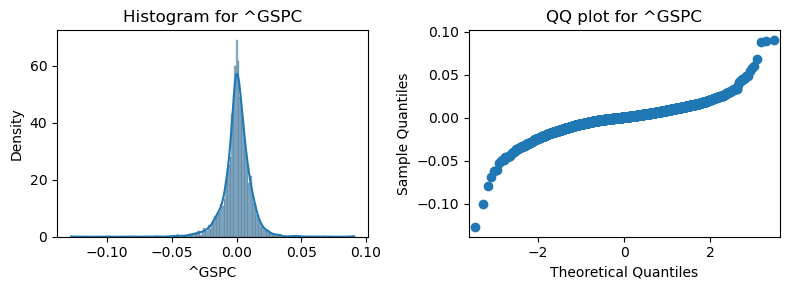

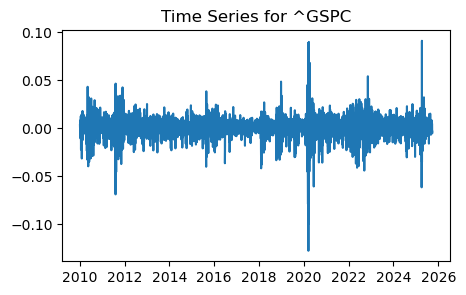

In [112]:
plot_distribution(logret, '^GSPC')
plot_series(logret, '^GSPC')

In [5]:
ticker = "^GSPC"
train_start = "2010-01-01"
train_end = "2024-12-31"
test_end = "2025-06-30"

LOOKBACK = 60
FORWARD = 5
NSIM = 100
SIG_LEVEL = 3
FREQ = 1

X_train = logret.loc[train_start:train_end, ticker].values
X_seed = X_train[-LOOKBACK:]
X_test = logret.loc[train_end:test_end, ticker].values[1:]

In [6]:
def build_library_bootstrap_pathwise(paths, lookback, sig_level, forward, dt):
    """
    Builds the library of (signature, future_path_segment) pairs.

    inputs:
    - paths: (n_paths, n_steps)
    - lookback: length of lookback window, int
    - sig_level: level of signature, int
    - forward: length of forward window, int
    
    return:
    - signatures_list: (num_windows, sig_dim)
    - future_segments_list: (num_windows, forward)
    """
    signatures_list, future_segments_list = [], []
    for path in paths:
        for i in trange(lookback, len(path) - forward):
            time_segment = np.arange(lookback) * dt
            past_segment = path[i-lookback:i]
            current_window = np.stack([time_segment, past_segment], axis=1)
            
            sig = iisignature.sig(current_window, sig_level)
            future_segment = path[i:i+forward] - path[i-1]

            signatures_list.append(sig)
            future_segments_list.append(future_segment)
    return np.array(signatures_list), np.array(future_segments_list)

def generate_path_bootstrap_pathwise(seed_path, n_total_steps, lookback, sig_level, dt, library_sigs, library_segments, k=10):
    """
    Generates a full path by appending historical path segments.

    inputs:
    - seed_path: historical path (init_steps,)
    """
    assert len(seed_path) >= lookback, "seed path not long enough"
    assert library_sigs.shape[1] == iisignature.siglength(2, sig_level), "incompatible library to signature level"
    gen_path_list = list(seed_path)

    while len(gen_path_list) < n_total_steps:
        past_segment = np.array(gen_path_list[-lookback:])
        time_segment = np.arange(lookback) * dt
        current_window = np.stack([time_segment, past_segment], axis=1)

        # find most similar window to current window in library
        query_sig = iisignature.sig(current_window, sig_level)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        chosen_neighbor_idx = np.random.choice(neighbor_indices)

        # predict with a random neighbor
        chosen_segment = library_segments[chosen_neighbor_idx]
        next_segment = gen_path_list[-1] + chosen_segment
        gen_path_list.extend(list(next_segment))

    return np.array(gen_path_list)[len(seed_path):n_total_steps]

In [7]:
library_sig, library_future = build_library_bootstrap_pathwise(
    [X_train], lookback=LOOKBACK, sig_level=SIG_LEVEL, forward=FORWARD, dt=FREQ)

100%|██████████| 3708/3708 [00:00<00:00, 62189.77it/s]


In [8]:
X_gens = []
for _ in range(NSIM):
    X_gens.append(
        generate_path_bootstrap_pathwise(
            X_seed, n_total_steps=LOOKBACK+len(X_test), lookback=LOOKBACK, sig_level=SIG_LEVEL, 
            dt=FREQ, library_sigs=library_sig, library_segments=library_future, k=10)
    )

In [22]:
Y0 = prices.loc[train_end, ticker]
Y_test = Y0 * np.exp(X_test.cumsum())
Y_gens = []
for i in range(NSIM):
    Y_gens.append(Y0 * np.exp(X_gens[i].cumsum()))

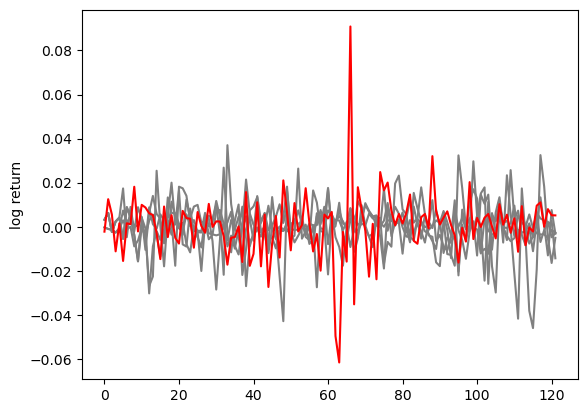

In [26]:
for path in X_gens[:5]:
    plt.plot(path, color = 'grey', label = 'generated')
plt.plot(X_test, color = 'red', label = 'realized')
plt.ylabel("log return")
plt.show()

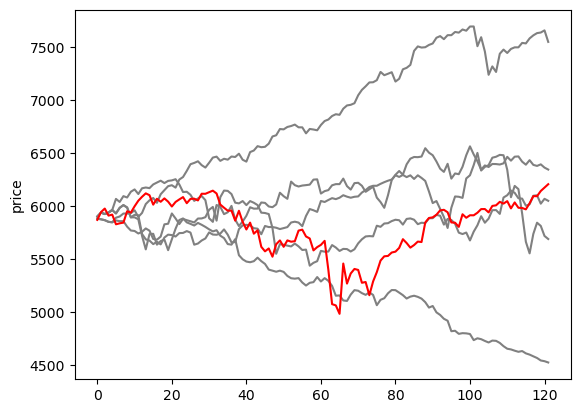

In [25]:
for path in Y_gens[:5]:
    plt.plot(path, color = 'grey', label = 'generated')
plt.plot(Y_test, color = 'red', label = 'realized')
plt.ylabel("price")
plt.show()